In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
from torch.nn.utils.rnn import pad_sequence
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from collections import defaultdict
from sklearn.isotonic import IsotonicRegression
from tqdm import tqdm

from model import ReachabilityModel, catchProb
from play_class import play

#### Create Array of Pandas Dataframes for each CSV File in Dataset

In [52]:
dfs = []
datapath = os.getcwd() + '\data'
for item in os.listdir(datapath):
    fullpath = os.path.join(datapath, item)
    if os.path.isfile(fullpath):
        dfs.append(pd.read_csv('data/' + item))

C:\Users\cwphu\AppData\Local\Temp\ipykernel_17076\3426312423.py:6: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv('data/' + item))


#### Clean Each Input/Output DF

In [53]:
def cleanInputData(df):
    cleandf = df.copy()
    # remove all plays where num frames >= 50 due to dataset tracking error
    cleandf = cleandf[cleandf['num_frames_output'] < 50]
    # generate unique play id by concatenating game id (game), play id (play)
    cleandf['unique_play_id'] = cleandf['game_id'].astype(str) + cleandf['play_id'].astype(str)
    # generate x/y components of velocity, acceleration
    cleandf['v_x'] = np.sin(cleandf['dir']*2*np.pi/360.0) * cleandf['s']
    cleandf['v_y'] = np.cos(cleandf['dir']*2*np.pi/360.0) * cleandf['s']
    cleandf['a_x'] = np.sin(cleandf['dir']*2*np.pi/360.0) * cleandf['a']
    cleandf['a_y'] = np.cos(cleandf['dir']*2*np.pi/360.0) * cleandf['a']
    cleandf['o'] = cleandf['o']/360.0
    cleandf = cleandf.drop(columns=['s', 'a', 'dir'])
    return cleandf

def cleanOutputData(df):
    cleandf = df.copy()
    cleandf['unique_play_id'] = cleandf['game_id'].astype(str) + cleandf['play_id'].astype(str)
    return cleandf

def cleanSupplementaryData(df):
    cleandf = df.copy()
    cleandf['unique_play_id'] = cleandf['game_id'].astype(str) + cleandf['play_id'].astype(str)
    return cleandf

In [54]:
clean_input_dfs = []
for i in range(0, 18):
    clean_input_dfs.append(cleanInputData(dfs[i]))
clean_output_dfs = []
for i in range(18, 36):
    clean_output_dfs.append(cleanOutputData(dfs[i]))

clean_sup_df = cleanSupplementaryData(dfs[36])

In [55]:
clean_input_dfs[0]

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,y,o,num_frames_output,ball_land_x,ball_land_y,unique_play_id,v_x,v_y,a_x,a_y
0,2023090700,101,False,54527,1,right,42,Bryan Cook,6-1,210,...,36.94,0.661778,21,63.259998,-0.22,2023090700101,-0.054913,0.071306,-0.237957,0.308993
1,2023090700,101,False,54527,2,right,42,Bryan Cook,6-1,210,...,36.94,0.655694,21,63.259998,-0.22,2023090700101,-0.014263,-0.037371,-0.217511,-0.569903
2,2023090700,101,False,54527,3,right,42,Bryan Cook,6-1,210,...,36.93,0.668333,21,63.259998,-0.22,2023090700101,0.064388,-0.101263,0.391691,-0.616018
3,2023090700,101,False,54527,4,right,42,Bryan Cook,6-1,210,...,36.92,0.678472,21,63.259998,-0.22,2023090700101,0.172526,-0.152102,0.607590,-0.535663
4,2023090700,101,False,54527,5,right,42,Bryan Cook,6-1,210,...,36.90,0.678472,21,63.259998,-0.22,2023090700101,0.292667,-0.191954,0.685676,-0.449720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285709,2023091100,3987,True,42489,29,left,87,Stefon Diggs,6-0,191,...,14.72,0.936528,11,73.870003,11.48,20230911003987,-3.941286,1.768804,-5.391898,2.419822
285710,2023091100,3987,True,42489,30,left,87,Stefon Diggs,6-0,191,...,14.88,0.013583,11,73.870003,11.48,20230911003987,-3.066950,1.623181,-5.895261,3.120063
285711,2023091100,3987,True,42489,31,left,87,Stefon Diggs,6-0,191,...,15.03,0.105167,11,73.870003,11.48,20230911003987,-2.303738,1.464818,-5.780441,3.675459
285712,2023091100,3987,True,42489,32,left,87,Stefon Diggs,6-0,191,...,15.16,0.144278,11,73.870003,11.48,20230911003987,-1.516783,1.209532,-5.355652,4.270772


#### Generate Player ID -> Name Dictionary

In [56]:
player_dict = dict()
for clean_dfs in clean_input_dfs:
    for _,row in clean_dfs.iterrows():
        id = row['nfl_id']
        if id not in player_dict:
            name = row['player_name']
            player_dict[id] = name

In [57]:
player_dict

{54527: 'Bryan Cook',
 46137: 'Justin Reid',
 52546: "L'Jarius Sneed",
 53487: 'Nick Bolton',
 54486: 'Trent McDuffie',
 53541: 'Amon-Ra St. Brown',
 53959: 'Brock Wright',
 43290: 'Jared Goff',
 44930: 'Josh Reynolds',
 44888: 'Alex Anzalone',
 55910: 'Brian Branch',
 47888: 'C.J. Gardner-Johnson',
 44906: 'Cameron Sutton',
 53953: 'Jerry Jacobs',
 54562: 'Kerby Joseph',
 54653: 'Malcolm Rodriguez',
 46213: 'Justin Watson',
 46243: 'Marquez Valdes-Scantling',
 53591: 'Noah Gray',
 54519: 'Skyy Moore',
 44822: 'Patrick Mahomes',
 41325: 'Jerick McKinnon',
 53542: 'Derrick Barnes',
 52440: 'Clyde Edwards-Helaire',
 46309: 'Richie James',
 54495: 'George Karlaftis',
 47882: 'Mike Edwards',
 43584: 'Kalif Raymond',
 55899: 'Sam LaPorta',
 38696: 'Marvin Jones',
 54600: 'Joshua Williams',
 55984: 'Chamarri Conner',
 52471: 'Willie Gay Jr.',
 47856: 'David Montgomery',
 55876: 'Jahmyr Gibbs',
 54568: 'Leo Chenal',
 46424: 'Jason Cabinda',
 55882: 'Jack Campbell',
 54716: 'Isiah Pacheco',
 5

#### Generate Play Id -> Coverage Dictionary

In [58]:
coverage_dict = dict()
for _,row in clean_sup_df.iterrows():
    id = row['unique_play_id']
    coverage_dict[id] = row['team_coverage_man_zone']

In [59]:
coverage_dict

{'20230907003461': 'ZONE_COVERAGE',
 '2023090700461': 'ZONE_COVERAGE',
 '20230907001940': 'ZONE_COVERAGE',
 '20230907001711': 'ZONE_COVERAGE',
 '20230907001588': 'ZONE_COVERAGE',
 '2023090700101': 'ZONE_COVERAGE',
 '20230907003566': 'MAN_COVERAGE',
 '2023090700902': 'MAN_COVERAGE',
 '20230907001069': 'ZONE_COVERAGE',
 '20230907002261': 'MAN_COVERAGE',
 '20230907002435': 'ZONE_COVERAGE',
 '20230907002906': 'ZONE_COVERAGE',
 '2023090700713': 'ZONE_COVERAGE',
 '20230907001741': 'MAN_COVERAGE',
 '20230907003971': 'ZONE_COVERAGE',
 '20230907003032': 'MAN_COVERAGE',
 '2023090700361': 'ZONE_COVERAGE',
 '20230907002638': 'MAN_COVERAGE',
 '2023090700736': 'MAN_COVERAGE',
 '20230907001154': 'ZONE_COVERAGE',
 '20230907001812': 'ZONE_COVERAGE',
 '20230907003089': 'ZONE_COVERAGE',
 '20230907001618': 'ZONE_COVERAGE',
 '20230907002306': 'ZONE_COVERAGE',
 '20230907002141': 'ZONE_COVERAGE',
 '20230907003324': 'MAN_COVERAGE',
 '20230907001001': 'MAN_COVERAGE',
 '20230907004041': 'ZONE_COVERAGE',
 '20230

#### Process Input Datasets

In [60]:
full_data = dict()

for clean_dfs in clean_input_dfs:
    for _,row in clean_dfs.iterrows():
        play_id = row['unique_play_id']

        # filter to only include zone coverage plays
        #if coverage_dict[play_id] == 'ZONE_COVERAGE':
        if play_id not in full_data.keys():
            full_data[play_id] = play()
        this_play = full_data[play_id]

        player_id = row['nfl_id']
        # if is player to predict
        if row['player_to_predict'] == True:
            this_play.target_player_id = player_id
            this_play.target_player_name = row['player_name']
            this_play.target_player_position = row['player_position']
            # log target info
            target_data = np.array([row['num_frames_output'], row['ball_land_x'], row['ball_land_y']])
            this_play.target = target_data
        
        # if is quarterback
        if row['player_position'] == "QB":
            this_play.quarterback_id = player_id
            this_play.quarterback_name = row['player_name']

        # add movement to player movement dict
        data = np.array([row['x'], row['y'], row['o'], row['v_x'], row['v_y'], row['a_x'], row['a_y']])
        if player_id not in this_play.player_movement_input:
            this_play.player_movement_input[player_id] = [data]
        else:
            this_play.player_movement_input[player_id].append(data)

#### Process Output Datasets

In [61]:
for clean_dfs in clean_output_dfs:
    for _,row in clean_dfs.iterrows():
        play_id = row['unique_play_id']

        if play_id in full_data.keys():
            this_play = full_data[play_id]

            player_id = row['nfl_id']
            data = np.array([row['x'], row['y']])
            
            if player_id not in this_play.player_movement_output:
                this_play.player_movement_output[player_id] = [data]
            else:
                this_play.player_movement_output[player_id].append(data)

#### Process Supplementary Dataset

In [62]:
for _,row in clean_sup_df.iterrows():
    play_id = row['unique_play_id']
    
    if play_id in full_data.keys():
        this_play = full_data[play_id]
        this_play.receiver_route = row['route_of_targeted_receiver']
        this_play.defensive_coverage = row['team_coverage_type']
        this_play.offense_team = row['possession_team']
        this_play.defense_team = row['defensive_team']
        this_play.pass_result = row['pass_result']

In [63]:
# Final consistency checks
for key in full_data.keys():
    if full_data[key].target_player_id == None:
        print(key)
        print('missing target player')
    if full_data[key].defensive_coverage == None:
        print(key)
        print('missing coverage')

#### Example Overlay Generation

In [64]:
temp_play = full_data['2023090700101']
temp_play.get_input_seq_len()

26

In [65]:
frame_idx = temp_play.get_input_seq_len()
coordsx, coordsy, overlays, open_score = temp_play.generate_overlays_and_score(frame_idx)
print(temp_play)

Play(
  target_player_id=44930,
  target_player_name=Josh Reynolds,
  target_player_position=WR,
  quarterback_id=43290,
  quarterback_name=Jared Goff,
  receiver_route=CORNER,
  defensive_coverage=COVER_2_ZONE,
  offense_team=DET,
  defense_team=KC,
  player_movement_input_keys=[54527, 46137, 52546, 53487, 54486, 53541, 53959, 43290, 44930],
  player_movement_output_keys=[46137, 52546, 44930],
  play output num frame_idxs=21.0,
  play ball land location=[63.25999832 -0.22      ],
  play result=I,
  play pass score=40.155280375982066
  play open score=35.500682512438175
)


#### Generate Overlays and Scores

In [66]:
for key in tqdm(full_data):
    temp_play = full_data[key]
    frame_idx = temp_play.get_input_seq_len()
    temp_play.generate_overlays_and_score(frame_idx)

100%|██████████| 14106/14106 [12:23<00:00, 18.98it/s]


#### Scale Scores and Save Results to CSV

In [120]:
processed_data = []
for key, play_obj in full_data.items():
    play_data = {
        'unique_play_id': key,
        'target_player_id': play_obj.target_player_id,
        'target_player_name': play_obj.target_player_name,
        'target_player_position': play_obj.target_player_position,
        'quarterback_id': play_obj.quarterback_id,
        'quarterback_name': play_obj.quarterback_name,
        'receiver_route': play_obj.receiver_route,
        'defensive_coverage': play_obj.defensive_coverage,
        'offense_team': play_obj.offense_team,
        'defense_team': play_obj.defense_team,
        'pass_result': play_obj.pass_result,
        'pass_score_raw': play_obj.pass_score,
        'open_score_raw': play_obj.open_score
    }
    processed_data.append(play_data)
processed_data_df = pd.DataFrame(processed_data)

In [121]:
processed_data_df

,unique_play_id,target_player_id,target_player_name,target_player_position,quarterback_id,quarterback_name,receiver_route,defensive_coverage,offense_team,defense_team,pass_result,pass_score_raw,open_score_raw
0,2023090700101,44930,Josh Reynolds,WR,43290.0,Jared Goff,CORNER,COVER_2_ZONE,DET,KC,I,40.155280,35.500683
1,2023090700194,41325,Jerick McKinnon,RB,44822.0,Patrick Mahomes,ANGLE,COVER_1_MAN,KC,DET,C,97.555042,16.970382
2,2023090700219,53591,Noah Gray,TE,44822.0,Patrick Mahomes,HITCH,COVER_4_ZONE,KC,DET,C,99.508961,17.599764
3,2023090700361,38696,Marvin Jones,WR,43290.0,Jared Goff,HITCH,COVER_4_ZONE,DET,KC,C,2.171917,15.070692
4,2023090700436,53541,Amon-Ra St. Brown,WR,43290.0,Jared Goff,SLANT,COVER_1_MAN,DET,KC,C,0.683227,9.745252
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14101,20240107133836,54613,Khalil Shakir,WR,46076.0,Josh Allen,SLANT,COVER_4_ZONE,BUF,MIA,C,64.830567,11.395252
14102,20240107133906,43454,Tyreek Hill,WR,52413.0,Tua Tagovailoa,HITCH,COVER_4_ZONE,MIA,BUF,C,91.072591,48.599944
14103,20240107133936,46192,Durham Smythe,TE,52413.0,Tua Tagovailoa,OUT,COVER_2_MAN,MIA,BUF,C,94.955595,6.236988
14104,20240107133995,43454,Tyreek Hill,WR,52413.0,Tua Tagovailoa,CORNER,COVER_2_ZONE,MIA,BUF,I,7.204177,21.864528


Text(0.5, 1.0, 'Pass Score Distribution')

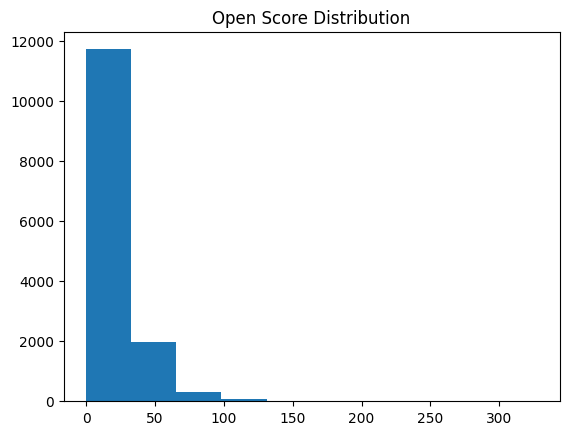

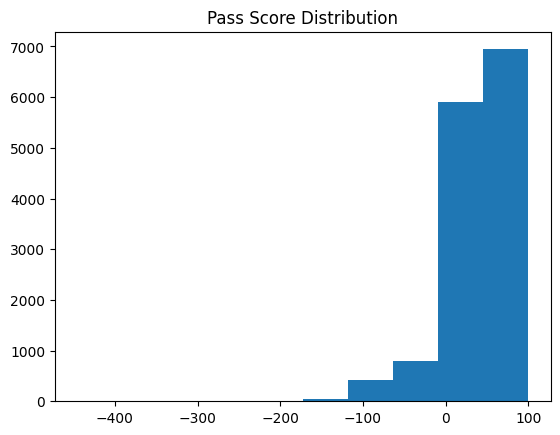

In [122]:
labels = processed_data_df['pass_result'].to_numpy()
open_scores = processed_data_df['open_score_raw'].to_numpy()
pass_scores = processed_data_df['pass_score_raw'].to_numpy()

plt.figure()
plt.hist(open_scores) 
plt.title('Open Score Distribution')

plt.figure()
plt.hist(pass_scores) 
plt.title('Pass Score Distribution')

In [125]:
processed_data_df["pass_pctile"] = (
    processed_data_df["pass_score_raw"]
           .rank(pct=True) * 100
)
processed_data_df["open_pctile"] = (
    processed_data_df["open_score_raw"]
           .rank(pct=True) * 100
)

In [126]:
model = catchProb(input_dim=2)

PATH = "D:\CWP_DATA\Documents\databowl_2025\model_params\catch_model.pth"
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint)

open_test = processed_data_df['open_pctile'].to_numpy()
open_test = torch.tensor(open_test, dtype=torch.float32).unsqueeze(1)
pass_test = processed_data_df['pass_pctile'].to_numpy()
pass_test = torch.tensor(pass_test, dtype=torch.float32).unsqueeze(1)
input_test = torch.hstack((open_test, pass_test))

expected_success = model(input_test).detach().numpy().squeeze(1)
processed_data_df['expected_C_pct'] = expected_success*100

In [127]:
print('Average Open Score: ' + str(np.average(open_scores)))
print('Median Open Score: ' + str(np.median(open_scores)))
p25, p75 = np.percentile(open_scores, [25, 75])
print(f"The 25th percentile (Q1) is: {p25}")
print(f"The 75th percentile (Q3) is: {p75}\n")

print('Average Pass Score: ' + str(np.average(pass_scores)))
print('Median Pass Score: ' + str(np.median(pass_scores)))
p25, p75 = np.percentile(pass_scores, [25, 75])
print(f"The 25th percentile (Q1) is: {p25}")
print(f"The 75th percentile (Q3) is: {p75}")

Average Open Score: 21.203376370788842
Median Open Score: 16.880480111672043
The 25th percentile (Q1) is: 10.106341267271596
The 75th percentile (Q3) is: 26.501426216526653

Average Pass Score: 41.66218627681753
Median Pass Score: 43.438841775370456
The 25th percentile (Q1) is: 1.2915887789011093
The 75th percentile (Q3) is: 91.84771266674453


Using these distributions, let's define: 
 - open receiver: score > 26.5
 - blanketed receiver: score < 10
 - exceptional pass: score > 91
 - bad pass: score < 1.3

In [134]:
processed_data_df['open_receiver'] = processed_data_df['open_pctile'] > 75.0
processed_data_df['blanketed_receiver'] = processed_data_df['open_pctile'] < 25.0
processed_data_df['exceptional_pass'] = processed_data_df['pass_pctile'] > 75.0
processed_data_df['bad_pass'] = processed_data_df['pass_pctile'] < 25.0

In [135]:
def label_row(row):
    if row["open_receiver"] and row["exceptional_pass"]:
        return "open + exceptional"
    if row["open_receiver"] and row["bad_pass"]:
        return "open + bad"
    if row["blanketed_receiver"] and row["exceptional_pass"]:
        return "covered + exceptional"
    if row["blanketed_receiver"] and row["bad_pass"]:
        return "covered + bad"
    return "typical"

processed_data_df["play_category"] = processed_data_df.apply(label_row, axis=1)

In [136]:
processed_data_df["splash_play"] = (processed_data_df["pass_result"] == "C") & (processed_data_df["expected_C_pct"] < 50)

In [137]:
processed_data_df

,unique_play_id,target_player_id,target_player_name,target_player_position,quarterback_id,quarterback_name,receiver_route,defensive_coverage,offense_team,defense_team,...,open_score_raw,pass_pctile,open_pctile,expected_C_pct,open_receiver,blanketed_receiver,exceptional_pass,bad_pass,play_category,splash_play
0,2023090700101,44930,Josh Reynolds,WR,43290.0,Jared Goff,CORNER,COVER_2_ZONE,DET,KC,...,35.500683,48.787750,85.942152,78.853157,True,False,False,False,typical,False
1,2023090700194,41325,Jerick McKinnon,RB,44822.0,Patrick Mahomes,ANGLE,COVER_1_MAN,KC,DET,...,16.970382,83.836665,50.396994,89.494446,False,False,True,False,typical,False
2,2023090700219,53591,Noah Gray,TE,44822.0,Patrick Mahomes,HITCH,COVER_4_ZONE,KC,DET,...,17.599764,92.173543,52.644265,91.910759,False,False,True,False,typical,False
3,2023090700361,38696,Marvin Jones,WR,43290.0,Jared Goff,HITCH,COVER_4_ZONE,DET,KC,...,15.070692,26.719127,43.385793,55.989639,False,False,False,False,typical,False
4,2023090700436,53541,Amon-Ra St. Brown,WR,43290.0,Jared Goff,SLANT,COVER_1_MAN,DET,KC,...,9.745252,23.330498,23.812562,49.103924,False,True,False,True,covered + bad,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14101,20240107133836,54613,Khalil Shakir,WR,46076.0,Josh Allen,SLANT,COVER_4_ZONE,BUF,MIA,...,11.395252,58.421948,29.285410,75.811348,False,False,False,False,typical,False
14102,20240107133906,43454,Tyreek Hill,WR,52413.0,Tua Tagovailoa,HITCH,COVER_4_ZONE,MIA,BUF,...,48.599944,74.181199,93.158939,89.993767,True,False,False,False,typical,False
14103,20240107133936,46192,Durham Smythe,TE,52413.0,Tua Tagovailoa,OUT,COVER_2_MAN,MIA,BUF,...,6.236988,79.001843,13.356019,84.153908,False,True,True,False,covered + exceptional,False
14104,20240107133995,43454,Tyreek Hill,WR,52413.0,Tua Tagovailoa,CORNER,COVER_2_ZONE,MIA,BUF,...,21.864528,32.546434,65.206295,64.911934,False,False,False,False,typical,False


In [138]:
processed_data_df.to_csv('processed_data.csv', index=False)

#### Generate Useful Metrics

In [140]:
player_metrics_df = processed_data_df.groupby(['target_player_name'], as_index=False).agg(
    position=('target_player_position', 'first'), 
    avg_pass_score=('pass_score_raw', 'mean'),
    median_pass_score=('pass_score_raw', 'median'),
    avg_open_score=('open_score_raw', 'mean'),
    median_open_score=('open_score_raw', 'median'),
    avg_expected_C_pct=('expected_C_pct', 'mean'),
    count=('open_score_raw', 'count'),
    splash_plays=('splash_play', lambda x: (x == True).sum()),
    I_count=('pass_result', lambda x: (x == 'I').sum()),
    C_count=('pass_result', lambda x: (x == 'C').sum()),
    open_count=('open_receiver', lambda x: (x == True).sum()),
    blanket_count=('blanketed_receiver', lambda x: (x == True).sum()),
    gp_count=('exceptional_pass', lambda x: (x == True).sum()),
    bp_count=('bad_pass', lambda x: (x == True).sum())
)
player_metrics_df['I_pct'] = player_metrics_df['I_count'] / player_metrics_df['count'] * 100.0
player_metrics_df['C_pct'] = player_metrics_df['C_count'] / player_metrics_df['count'] * 100.0

MIN_TOTAL_PLAYS = 40
player_totals = player_metrics_df.groupby("target_player_name")["count"].sum()
eligible_players = player_totals[player_totals >= MIN_TOTAL_PLAYS].index

filtered_player_metrics_df = player_metrics_df[
    (player_metrics_df["target_player_name"].isin(eligible_players))
].copy()

filtered_player_metrics_df["pass_pctile"] = (
    filtered_player_metrics_df["avg_pass_score"]
           .rank(pct=True) * 100
)
filtered_player_metrics_df["open_pctile"] = (
    filtered_player_metrics_df["avg_open_score"]
           .rank(pct=True) * 100
)

filtered_player_metrics_df["CPA"] = filtered_player_metrics_df["C_pct"] - filtered_player_metrics_df["avg_expected_C_pct"]

filtered_player_metrics_df.to_csv('player_metrics.csv', index=False)
filtered_player_metrics_df.head()

,target_player_name,position,avg_pass_score,median_pass_score,avg_open_score,median_open_score,avg_expected_C_pct,count,splash_plays,I_count,C_count,open_count,blanket_count,gp_count,bp_count,I_pct,C_pct,pass_pctile,open_pctile,CPA
0,A.J. Brown,WR,34.625755,30.052961,18.176058,15.995638,66.489883,139,18,35,101,31,45,28,41,25.179856,72.661871,43.307087,20.472441,6.171987
5,Adam Thielen,WR,38.580590,42.615141,18.642201,15.257638,68.428719,123,11,31,91,26,35,26,30,25.203252,73.983740,59.055118,27.559055,5.555021
9,Alec Pierce,WR,21.513975,8.720476,16.574219,14.120859,61.219147,61,6,28,32,9,20,11,27,45.901639,52.459016,6.299213,7.874016,-8.760130
13,Allen Lazard,WR,25.187003,9.591903,19.304177,14.580696,63.261269,46,3,22,23,12,13,5,14,47.826087,50.000000,13.385827,36.220472,-13.261269
14,Allen Robinson,WR,44.527560,58.346566,20.874704,14.088830,71.781937,40,3,7,32,12,11,11,8,17.500000,80.000000,74.015748,58.267717,8.218063


In [80]:
team_off_metrics = processed_data_df.groupby('offense_team', as_index=False).agg(
    avg_pass_score=('pass_score_scaled', 'mean'),
    median_pass_score=('pass_score_scaled', 'median'),
    avg_open_score=('open_score_scaled', 'mean'),
    median_open_score=('open_score_scaled', 'median'),
    count=('open_score_scaled', 'count'),
    I_count=('pass_result', lambda x: (x == 'I').sum()),
    C_count=('pass_result', lambda x: (x == 'C').sum())
)
team_off_metrics['I_pct'] = team_off_metrics['I_count'] / team_off_metrics['count']
team_off_metrics['C_pct'] = team_off_metrics['C_count'] / team_off_metrics['count']

team_off_metrics.to_csv('offense_metrics.csv', index=False)
team_off_metrics.head()

,offense_team,avg_pass_score,median_pass_score,avg_open_score,median_open_score,count,I_count,C_count,I_pct,C_pct
0,ARI,72.077086,75.648699,22.679580,17.829797,436,120,303,0.275229,0.694954
1,ATL,69.182828,69.281164,22.910378,18.097299,416,129,274,0.310096,0.658654
2,BAL,72.271994,73.000500,25.031928,19.606059,381,110,266,0.288714,0.698163
3,BUF,72.455355,75.847548,25.085773,19.900561,450,114,322,0.253333,0.715556
4,CAR,71.364696,70.039656,24.119922,18.714622,441,136,297,0.308390,0.673469


In [81]:
avg_scores = team_off_metrics['avg_pass_score'].to_numpy()
med_scores = team_off_metrics['median_pass_score'].to_numpy()
c_pct = team_off_metrics['C_pct'].to_numpy()

avg_correlation_matrix = np.corrcoef(avg_scores, c_pct)
avg_correlation_coefficient = avg_correlation_matrix[0, 1]
med_correlation_matrix = np.corrcoef(med_scores, c_pct)
med_correlation_coefficient = med_correlation_matrix[0, 1]
print(f"Avg Pass -> C_pct Correlation: {avg_correlation_coefficient}")
print(f"Med Pass -> C_pct Correlation: {med_correlation_coefficient}")

Avg Pass -> C_pct Correlation: 0.49076408494701695
Med Pass -> C_pct Correlation: 0.47869682841199473


In [82]:
avg_scores = team_off_metrics['avg_open_score'].to_numpy()
med_scores = team_off_metrics['median_open_score'].to_numpy()
c_pct = team_off_metrics['C_pct'].to_numpy()

avg_correlation_matrix = np.corrcoef(avg_scores, c_pct)
avg_correlation_coefficient = avg_correlation_matrix[0, 1]
med_correlation_matrix = np.corrcoef(med_scores, c_pct)
med_correlation_coefficient = med_correlation_matrix[0, 1]
print(f"Avg Open -> C_pct Correlation: {avg_correlation_coefficient}")
print(f"Med Open -> C_pct Correlation: {med_correlation_coefficient}")

Avg Open -> C_pct Correlation: 0.34518423038654444
Med Open -> C_pct Correlation: 0.4182673970884147


In [83]:
team_def_metrics = processed_data_df.groupby('defense_team', as_index=False).agg(
    avg_pass_score=('pass_score_scaled', 'mean'),
    median_pass_score=('pass_score_scaled', 'median'),
    avg_open_score=('open_score_scaled', 'mean'),
    median_open_score=('open_score_scaled', 'median'),
    count=('open_score_scaled', 'count'),
    I_count=('pass_result', lambda x: (x == 'I').sum()),
    C_count=('pass_result', lambda x: (x == 'C').sum())
)
team_def_metrics['I_pct'] = team_def_metrics['I_count'] / team_def_metrics['count']
team_def_metrics['C_pct'] = team_def_metrics['C_count'] / team_def_metrics['count']

team_def_metrics.to_csv('defense_metrics.csv', index=False)
team_def_metrics.head()

,defense_team,avg_pass_score,median_pass_score,avg_open_score,median_open_score,count,I_count,C_count,I_pct,C_pct
0,ARI,72.497064,76.565870,24.011816,19.403438,386,89,289,0.230570,0.748705
1,ATL,69.214285,64.836770,21.291982,16.491730,428,131,289,0.306075,0.675234
2,BAL,67.915270,64.545441,20.850272,17.308332,479,150,316,0.313152,0.659708
3,BUF,71.601494,72.437198,23.238953,18.947955,416,102,300,0.245192,0.721154
4,CAR,69.759687,66.397809,23.775085,20.247016,355,103,247,0.290141,0.695775


In [84]:
avg_scores = team_def_metrics['avg_pass_score'].to_numpy()
med_scores = team_def_metrics['median_pass_score'].to_numpy()
c_pct = team_def_metrics['C_pct'].to_numpy()

avg_correlation_matrix = np.corrcoef(avg_scores, c_pct)
avg_correlation_coefficient = avg_correlation_matrix[0, 1]
med_correlation_matrix = np.corrcoef(med_scores, c_pct)
med_correlation_coefficient = med_correlation_matrix[0, 1]
print(f"Avg Pass -> C_pct Correlation: {avg_correlation_coefficient}")
print(f"Med Pass -> C_pct Correlation: {med_correlation_coefficient}")

Avg Pass -> C_pct Correlation: 0.5328113015288872
Med Pass -> C_pct Correlation: 0.48117647257470486


In [85]:
avg_scores = team_def_metrics['avg_open_score'].to_numpy()
med_scores = team_def_metrics['median_open_score'].to_numpy()
c_pct = team_def_metrics['C_pct'].to_numpy()

avg_correlation_matrix = np.corrcoef(avg_scores, c_pct)
avg_correlation_coefficient = avg_correlation_matrix[0, 1]
med_correlation_matrix = np.corrcoef(med_scores, c_pct)
med_correlation_coefficient = med_correlation_matrix[0, 1]
print(f"Avg Open -> C_pct Correlation: {avg_correlation_coefficient}")
print(f"Med Open -> C_pct Correlation: {med_correlation_coefficient}")

Avg Open -> C_pct Correlation: 0.39897839026533316
Med Open -> C_pct Correlation: 0.2916584073732628


#### Open/Pass Score Metrics

Average Score: 25.724717386972628
Median Score: 20.845121462997355


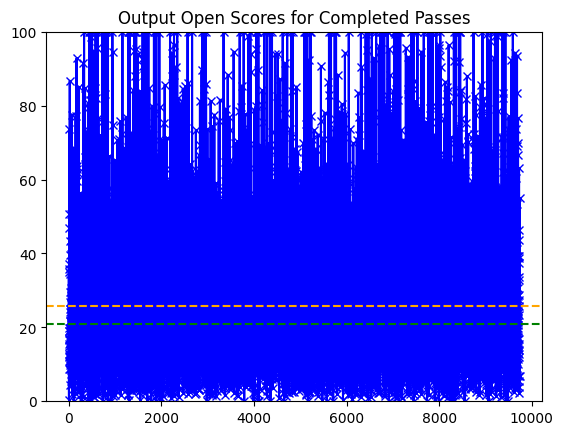

In [86]:
plt.plot(open_scores[labels=='C'], color='blue', marker='x', linestyle='-')
plt.axhline(y=np.average(open_scores[labels=='C']), color='orange', linestyle='--', label='Average')
plt.axhline(y=np.median(open_scores[labels=='C']), color='green', linestyle='--', label='Median')
plt.ylim((0, 100))
plt.title('Output Open Scores for Completed Passes')

print('Average Score: ' + str(np.average(open_scores[labels=='C'])))
print('Median Score: ' + str(np.median(open_scores[labels=='C'])))

Average Score: 18.587930463869178
Median Score: 13.507541738604719


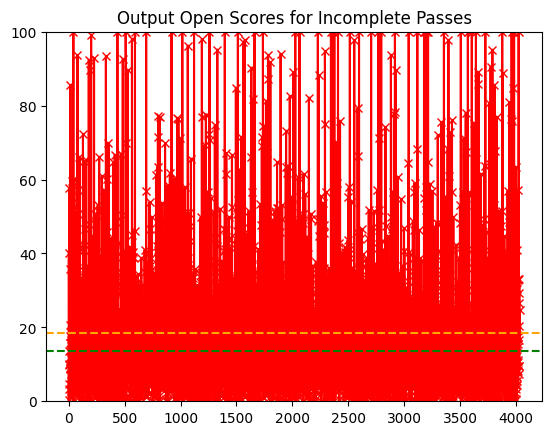

In [87]:
plt.plot(open_scores[labels=='I'], color='red', marker='x', linestyle='-')
plt.axhline(y=np.average(open_scores[labels=='I']), color='orange', linestyle='--', label='Average')
plt.axhline(y=np.median(open_scores[labels=='I']), color='green', linestyle='--', label='Median')
plt.ylim((0, 100))
plt.title('Output Open Scores for Incomplete Passes')

print('Average Score: ' + str(np.average(open_scores[labels=='I'])))
print('Median Score: ' + str(np.median(open_scores[labels=='I'])))

Average Score: 77.40436823758462
Median Score: 84.44912833911769


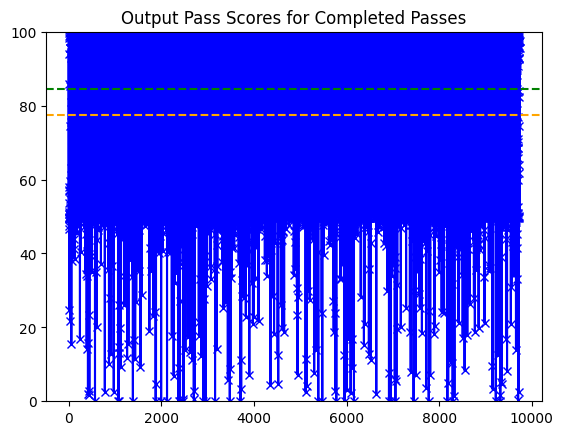

In [88]:
plt.plot(pass_scores[labels=='C'], color='blue', marker='x', linestyle='-')
plt.axhline(y=np.average(pass_scores[labels=='C']), color='orange', linestyle='--', label='Average')
plt.axhline(y=np.median(pass_scores[labels=='C']), color='green', linestyle='--', label='Median')
plt.ylim((0, 100))
plt.title('Output Pass Scores for Completed Passes')

print('Average Score: ' + str(np.average(pass_scores[labels=='C'])))
print('Median Score: ' + str(np.median(pass_scores[labels=='C'])))

Average Score: 57.48074816771834
Median Score: 51.301210773332556


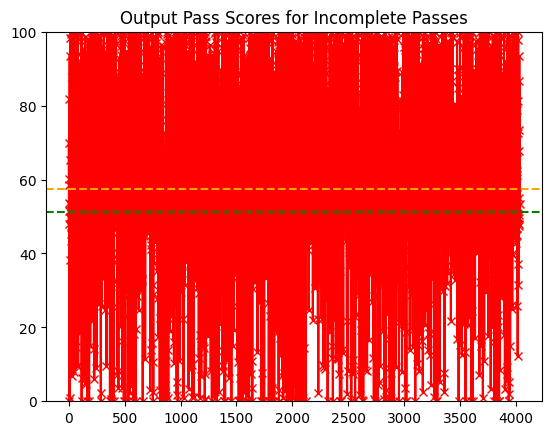

In [89]:
plt.plot(pass_scores[labels=='I'], color='red', marker='x', linestyle='-')
plt.axhline(y=np.average(pass_scores[labels=='I']), color='orange', linestyle='--', label='Average')
plt.axhline(y=np.median(pass_scores[labels=='I']), color='green', linestyle='--', label='Median')
plt.ylim((0, 100))
plt.title('Output Pass Scores for Incomplete Passes')

print('Average Score: ' + str(np.average(pass_scores[labels=='I'])))
print('Median Score: ' + str(np.median(pass_scores[labels=='I'])))

#### Train Open + Pass Score -> Completion Prob (Only Need to Run Once to Train Model)

In [106]:
label_mask = (labels == 'C').astype(float)
label_mask = torch.tensor(label_mask, dtype=torch.float32).unsqueeze(1)
print(label_mask.shape)

torch.Size([14106, 1])


In [111]:
open_test = processed_data_df['open_pctile'].to_numpy()
open_test = torch.tensor(open_test, dtype=torch.float32).unsqueeze(1)
print(open_test.shape)
pass_test = processed_data_df['pass_pctile'].to_numpy()
pass_test = torch.tensor(pass_test, dtype=torch.float32).unsqueeze(1)
print(pass_test.shape)
input_test = torch.hstack((open_test, pass_test))
print(input_test.shape)

torch.Size([14106, 1])
torch.Size([14106, 1])
torch.Size([14106, 2])


In [113]:
model = catchProb(input_dim=2)
loss_fn = nn.BCELoss()
opt = optim.Adam(model.parameters(), lr=1e-3)

dataset = TensorDataset(input_test, label_mask)
N = len(dataset)
val_size = int(0.2 * N)
train_size = N - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader  = DataLoader(val_ds, batch_size=64, shuffle=False)

# Model, loss, optimizer
model = catchProb(input_dim=2)
loss_fn = nn.BCELoss()
opt = optim.Adam(model.parameters(), lr=1e-3)

# --------------------------------------------------
# Training Loop
# --------------------------------------------------
epochs = 30
for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0.0

    for xb, yb in train_loader:
        opt.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        opt.step()
        train_loss += loss.item() * len(xb)

    train_loss /= train_size

    # ---------------- Validation ----------------
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb)
            loss = loss_fn(preds, yb)
            val_loss += loss.item() * len(xb)

            predicted_labels = (preds >= 0.5).float()
            correct += (predicted_labels == yb).sum().item()
            total += len(xb)

    val_loss /= val_size
    val_acc = correct / total

    print(f"Epoch {epoch:3d} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f} | "
            f"Val Acc: {val_acc:.4f}")          

Epoch   1 | Train Loss: 15.9797 | Val Loss: 7.1260 | Val Acc: 0.6920
Epoch   2 | Train Loss: 1.4860 | Val Loss: 0.5394 | Val Acc: 0.7426
Epoch   3 | Train Loss: 0.5360 | Val Loss: 0.5271 | Val Acc: 0.7462
Epoch   4 | Train Loss: 0.5332 | Val Loss: 0.5270 | Val Acc: 0.7572
Epoch   5 | Train Loss: 0.5322 | Val Loss: 0.5261 | Val Acc: 0.7480
Epoch   6 | Train Loss: 0.5320 | Val Loss: 0.5271 | Val Acc: 0.7373
Epoch   7 | Train Loss: 0.5311 | Val Loss: 0.5254 | Val Acc: 0.7565
Epoch   8 | Train Loss: 0.5312 | Val Loss: 0.5242 | Val Acc: 0.7572
Epoch   9 | Train Loss: 0.5307 | Val Loss: 0.5239 | Val Acc: 0.7536
Epoch  10 | Train Loss: 0.5303 | Val Loss: 0.5250 | Val Acc: 0.7462
Epoch  11 | Train Loss: 0.5298 | Val Loss: 0.5221 | Val Acc: 0.7572
Epoch  12 | Train Loss: 0.5295 | Val Loss: 0.5231 | Val Acc: 0.7494
Epoch  13 | Train Loss: 0.5294 | Val Loss: 0.5234 | Val Acc: 0.7547
Epoch  14 | Train Loss: 0.5295 | Val Loss: 0.5222 | Val Acc: 0.7565
Epoch  15 | Train Loss: 0.5284 | Val Loss: 0.52

In [93]:
## Save off model params
PATH = "D:\CWP_DATA\Documents\databowl_2025\model_params\catch_model.pth"
torch.save(model.state_dict(), PATH)